# Threshold for $F_1$ score calculation
---
The optimal thresholds for converting the probabilities obtained after prediction -- as returned by the sigmoid activation function of the neural network -- to labels (0 or 1) is determined using the [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) (MCC). The MCC is a correlation coefficient between the observed and predicted binary classifications. It returns a value between −1 and +1. A coefficient of +1 indicates a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. The MCC takes into account true and false positives and negatives.

The training dataset is divided into equal sets and model developed in this [notebook](nn.ipynb) is used to make predictions. Then, for each set, the pedictions are grouped by business and the mean prediction is calculated for each label and thresholded. We investigate multiple values for the threshold ranging from 0.4 to 0.6 and determine for each label the threshold that maximize the MCC.


## 1. Get Data

### A. Tensors and Targets

The ResNet50 bottleneck features along with the associated targets are loaded.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from common import *

%matplotlib inline

# Load Bottleneck Features
features = np.load('data/bottleneck_features/yelp_resnet50_all.npz')

# Features
X = features['train_features']

# Targets
y = features['train_targets']

print('Number of features: %d' % len(X))

Using TensorFlow backend.


Number of features: 176131


### B. Image Id
We load the id of the images in the dataset as well was the table linking the photo id to the business id.

In [2]:
import pandas as pd

ids, _ = load_dataset('data/preprocess/train.npz')

# Map the id of the photo to its index in (X,y)
p2id = dict(zip(ids,range(len(ids))))

# Read file mapping photo to business
p2b = pd.read_csv('data/train_photo_to_biz_ids.csv', header = 0, names = ['photo','business'])

## 2. Parameters of the Test

The training dataset is divided into 14 samples. The thresholds span from 0.4 to 0.6 by steps of 0.01. 

In [3]:
# Bins
bins = np.arange(0, len(X)+1, 12580)

# Thresholds
threshold = np.arange(0.4,0.6,0.01)

## 3. Classification

For each sample, we make predictions using the classifier trained in [nn.ipynb](resnet50.ipynb) and average the output probabilities per business.  

In [4]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=X.shape[1:]))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())

model.add(Dense(9, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

Predictions are made using the above neural network. The weights, which have been calculated in this [notebook](nn.ipynb), are loaded.

In [5]:
model.load_weights('data/saved_models/weights_resnet50.hdf5')
predictions = model.predict(X)

For each sample, we group the images by business and derive an average probability for each label. Using a unique threshold of 0.5 for each label, we calculate the $F_1$ score for each sample. Note that the score is high because we make predictions using the training dataset, i.e., the same dataset that has been used to train the model.

In [6]:
combine = []
label = []

for s in range(0, len(bins)-1):
    p2b_bin = p2b[p2b['photo'].isin(ids[bins[s]:bins[s+1]])]
    b2p_bin = pd.DataFrame(p2b_bin.groupby('business')['photo'].apply(list))
    biz_bin = b2p_bin.index.values
    bags_bin = []
    for b in biz_bin:
        photos = b2p_bin.get_value(b,'photo')
        if len(photos) >= 1:
            bags_bin.append([p2id[photo] for photo in photos])
    
    combine_sample = []
    label_sample = []
    for i, biz in enumerate(bags_bin):
        combine_sample.append(np.mean(predictions[biz],axis=0))
        label_sample.append(y[biz[0]])
    
    combine.append(np.array(combine_sample))
    label.append(np.array(label_sample))
    
    score_sample = f1_score(np.array(label_sample), (np.array(combine_sample) >= 0.5).astype(int))
    print("F1 score = %.5f for sample %d" % (score_sample, s+1))

F1 score = 0.84837 for sample 1
F1 score = 0.84469 for sample 2
F1 score = 0.84878 for sample 3
F1 score = 0.84800 for sample 4
F1 score = 0.84949 for sample 5
F1 score = 0.84813 for sample 6
F1 score = 0.84882 for sample 7
F1 score = 0.84719 for sample 8
F1 score = 0.84683 for sample 9
F1 score = 0.84740 for sample 10
F1 score = 0.84908 for sample 11
F1 score = 0.85079 for sample 12
F1 score = 0.84916 for sample 13
F1 score = 0.84886 for sample 14


## 4. Results

### A. Unique Threshold
We apply a unique threshold to all 9 classes. The box and violin plots below show that a threshold of about 0.5 maximize the $F_1$ score.

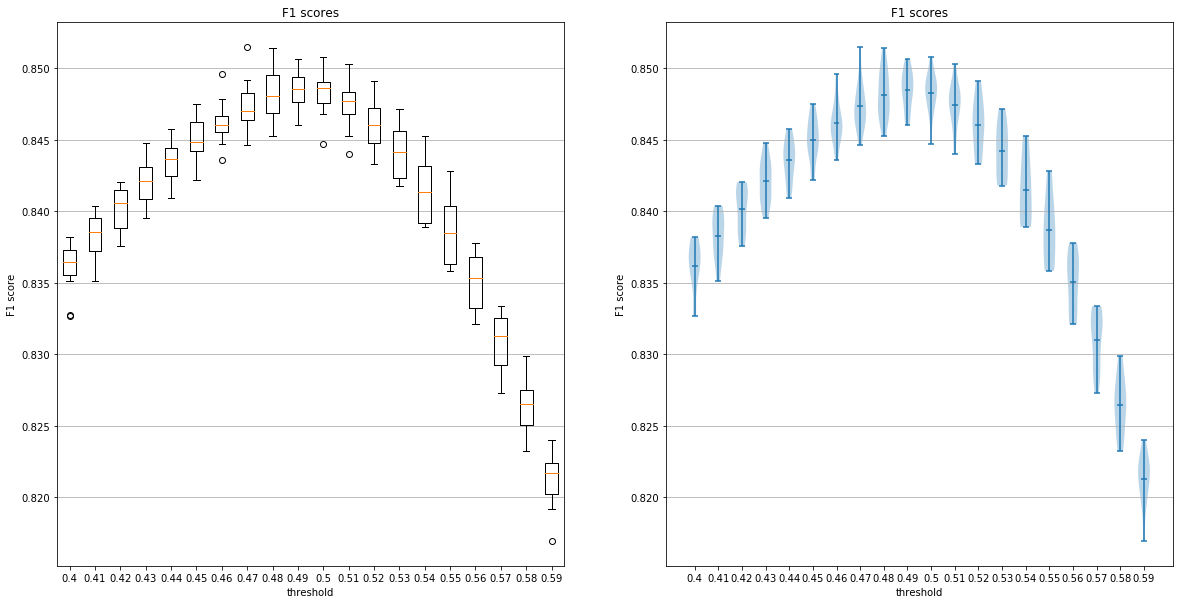

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

score = []
for t in threshold:
    score.append([f1_score(np.array(label[s]), (np.array(combine[s]) >= t).astype(int)) for s in range(len(combine))])


# plots
axes[0].boxplot(score)
axes[1].violinplot(score, showmeans=True, showmedians=False)

for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([i+1 for i in range(len(threshold))])
    ax.set_xlabel('threshold')
    ax.set_ylabel('F1 score')
    ax.set_xticklabels(map(str,threshold))
    

# add x-tick labels
plt.setp(axes, xticks=[i+1 for i in range(len(threshold))])
plt.show()

### B. Matthews Correlation Coefficient

In [8]:
from sklearn.metrics import matthews_corrcoef

best_threshold = []

for s in range(len(combine)):
    combine_sample, label_sample = (combine[s], label[s])
    for l in range(9):
        mcc = []
        for t in threshold:
            mcc.append(matthews_corrcoef(label_sample[:,l],(combine_sample[:,l] >= t).astype(int)))
        mcc = np.array(mcc)
        best_threshold.append(threshold[np.where(mcc==mcc.max())[0][0]])

best_threshold = np.median(np.array(best_threshold).reshape(len(combine),9), axis=0)

In [9]:
for s in range(len(combine)):
    combine_sample, label_sample = (combine[s], label[s])
    predictions_sample = []
    reference_sample = []
    for b in range(len(combine_sample)):
        for l in range(len(combine_sample[0])):
            predictions_sample.append(1 if combine_sample[b,l] >= best_threshold[l] else 0)
            reference_sample.append(1 if combine_sample[b,l] >= 0.5 else 0)
    predictions_sample = np.array(predictions_sample).reshape(len(combine_sample),9)
    reference_sample = np.array(reference_sample).reshape(len(combine_sample),9)

    print('F1 score: %.5f (sample %d), %.5f (threshold = 0.5)' % (f1_score(label_sample, 
                                                                           predictions_sample),
                                                                  s+1,
                                                                  f1_score(label_sample,
                                                                           reference_sample)))

F1 score: 0.84637 (sample 1), 0.84837 (threshold = 0.5)
F1 score: 0.84454 (sample 2), 0.84469 (threshold = 0.5)
F1 score: 0.84797 (sample 3), 0.84878 (threshold = 0.5)
F1 score: 0.84735 (sample 4), 0.84800 (threshold = 0.5)
F1 score: 0.85038 (sample 5), 0.84949 (threshold = 0.5)
F1 score: 0.84863 (sample 6), 0.84813 (threshold = 0.5)
F1 score: 0.84743 (sample 7), 0.84882 (threshold = 0.5)
F1 score: 0.84703 (sample 8), 0.84719 (threshold = 0.5)
F1 score: 0.84561 (sample 9), 0.84683 (threshold = 0.5)
F1 score: 0.84522 (sample 10), 0.84740 (threshold = 0.5)
F1 score: 0.84815 (sample 11), 0.84908 (threshold = 0.5)
F1 score: 0.85089 (sample 12), 0.85079 (threshold = 0.5)
F1 score: 0.84928 (sample 13), 0.84916 (threshold = 0.5)
F1 score: 0.84724 (sample 14), 0.84886 (threshold = 0.5)


In [10]:
print(best_threshold)

[ 0.43   0.55   0.535  0.525  0.545  0.54   0.55   0.47   0.5  ]
